In [1]:
import librosa
import librosa.display
import scipy.io.wavfile as wav
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from shutil import copyfile

In [66]:
data_dir = Path('/home/hayden/proj/ml/meow_stop/meows/')
wav_files = list(data_dir.glob('**/*.wav'))
print('Num files: {}.'.format(len(wav_files)))

Num files: 163.


In [74]:
# First, ensure all data has the same frame rate and number of channels.

audio_arrays = []
max_len = 0
longest_file = ''

for f in wav_files:
    audio, sample_rate = librosa.load(f)
    audio_arrays.append(audio)
    
    if len(audio) > max_len:
        print('Old max: {}, new max: {}.'.format(max_len, len(audio)))
        max_len = len(audio)
        longest_file = f
        
max_len_seconds = max_len / sample_rate
print('Longest file is {} at {} seconds.'.format(longest_file, max_len_seconds))
# num_frames.sort(reverse=True, key = lambda x: x[1])
# print(num_frames[0])
# print(max(num_frames, key=lambda item:item[1]))

# unique_sample_rates, counts = np.unique(sample_rates, return_counts=True)
# plt.bar([str(sr) for sr in unique_sample_rates], counts)
# plt.show()

# unique_num_channels, counts = np.unique(num_channels, return_counts=True)
# plt.bar([str(nc) for nc in unique_num_channels], counts)
# plt.show()

Old max: 0, new max: 12388.
Old max: 12388, new max: 20795.
Old max: 20795, new max: 21236.
Old max: 21236, new max: 22565.
Old max: 22565, new max: 25693.
Old max: 25693, new max: 29841.
Old max: 29841, new max: 31551.
Old max: 31551, new max: 33310.
Old max: 33310, new max: 42804.
Longest file is /home/hayden/proj/ml/meow_stop/meows/kaggle/cat_13_0.wav at 1.9412244897959183 seconds.


In [68]:
# Make all clips the same length by adding zero padding to the end of those that are shorter than the longest one.
# audio_arrays_padded = [np.pad(audio_array, (0, max_len - len(audio_array)), 'constant', constant_values=(0, 0)) for audio_array in audio_arrays]

In [69]:
# From here: https://medium.com/@mikesmales/sound-classification-using-deep-learning-8bc2aa1990b7
def extract_features(audio):
    # Only keep coefficients 2-13 and subtract the means of each (https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html)
#     mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)[2:14].T
#     mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
#     return mfcc
    
    # Only keep coefficients 2-13 and take the average of each
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)[2:14]
    mfcc_avgs = np.mean(mfcc, axis=1)     
    return mfcc_avgs

In [70]:
features_per_file = np.stack([extract_features(a) for a in audio_arrays], axis=0)
print(features_per_file.shape)
columns = ['mfcc_' + str(i) for i in range(2, 14)]
df = pd.DataFrame(features_per_file, columns=columns)
df.head()

(163, 12)


,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13
0,-90.224014,41.141239,-20.184118,27.250246,-43.306591,22.062889,-19.886065,-0.633164,14.530294,-14.261170,-0.049259,-23.300520
1,-71.721321,52.600670,-22.982832,23.071135,-28.568306,13.368711,-19.530357,-6.280271,8.341313,-12.621789,7.931168,-14.389843
2,-57.468460,9.802992,-18.484432,26.040045,-37.638596,20.687260,-11.287644,1.990124,13.307290,-11.054138,-13.097839,-24.853971
3,-63.481346,41.639458,-24.303101,24.595953,-37.543724,8.330663,-11.040250,7.654106,14.313297,-10.909854,-11.700035,-34.658184
4,-69.635307,29.803057,-14.485731,39.146622,-12.947083,10.403741,4.183125,3.120703,3.511979,-3.837701,5.892772,-6.472486


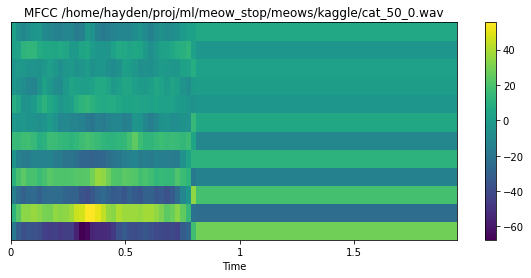

In [44]:
# plt.figure(figsize=(10, 4))
# librosa.display.specshow(features_per_file[10].T, x_axis='time', cmap='viridis')
# plt.colorbar()
# plt.title('MFCC {}'.format(wav_files[10]))
# plt.show()

In [3]:
us8k_csv = '/home/hayden/proj/ml/meow_stop/UrbanSound8K/metadata/UrbanSound8K.csv'
us8k_df = pd.read_csv(us8k_csv)
us8k_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [79]:
us8k_df['class'].unique()

array(['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
       'street_music', 'gun_shot', 'siren', 'engine_idling', 'jackhammer',
       'drilling'], dtype=object)

I'm interested in these classes for negatives:
- children_playing
- car_horn
- air_conditioner
- street_music
- siren
- engine_idling
We'll see how many positives we have, then divide that by the number of classes for negatives above (6). We'll then randomly select that many examples from each negative class for the dataset.

In [4]:
classes = ['children_playing',
           'car_horn',
           'air_conditioner',
           'street_music',
           'siren',
           'engine_idling']

meow_dir = Path('/home/hayden/proj/ml/meow_stop/data/meow/')
not_meow_dir = Path('/home/hayden/proj/ml/meow_stop/data/not_meow/')
us8k_dir = Path('/home/hayden/proj/ml/meow_stop/UrbanSound8K/audio')

num_positives = len(list(meow_dir.glob('*.wav')))
num_negatives_per_class = int(num_positives / len(classes))
print('# positives: {}.'.format(num_positives))
print('# negatives: {}.'.format(num_negatives_per_class * len(classes)))

for c in classes:
    print('Processing negative class {}.'.format(c))
    
    # Grab num_negatives_per_class random files from the class
    class_rows = us8k_df[us8k_df['class'] == c]
    random_class_files = class_rows['slice_file_name'].sample(n=num_negatives_per_class)
    
    # Copy them to the dataset negatives directory
    random_class_files.apply(lambda f: copyfile(Path(us8k_dir, f), Path(not_meow_dir, f)))

# positives: 192.
# negatives: 192.
Processing negative class children_playing.
Processing negative class car_horn.
Processing negative class air_conditioner.
Processing negative class street_music.
Processing negative class siren.
Processing negative class engine_idling.
